In [1]:
import os
import random
import sp_peaks
from sp_peaks import slics
from sp_peaks import mapping
from sp_peaks import summary_statistics
from sp_peaks import plotting
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from lenspack.geometry.projections.gnom import radec2xy
from lenspack.utils import bin2d
from lenspack.image.inversion import ks93
import lenspack.peaks as peaks
from lenspack.starlet_l1norm import noise_coeff, get_l1norm_noisy
from lenspack.image.transforms import starlet2d
from astropy.stats import mad_std

Make master file

In [ ]:
# Define the root directory
root_directory = "/n17data/tersenov/Cov_DES_SLICS"

# Open the master text file in write mode
master_file_path = ".././input/master_file_cov.txt"
with open(master_file_path, "w") as master_file:
    for subdir in os.listdir(root_directory):
        # Check if the subdirectory name matches the pattern "LOS..."
        if subdir.startswith("LOS") and subdir[3:].isdigit():
            subdir_path = os.path.join(root_directory, subdir)
            
            # Iterate over the files in the subdirectory
            for file_name in os.listdir(subdir_path):
                # Check if the file name matches the desired pattern
                if file_name.startswith("DES_MocksCat_SLICS_4_Bin") and file_name.endswith(".dat"):
                    file_path = os.path.join(subdir_path, file_name)
                    master_file.write(file_path + "\n")

In [3]:
# Define the path to the "master_file_cov.txt"
master_file_path = ".././input/master_file_cov.txt"

Parse the filenames

In [4]:
# Read the file paths from the "master_file_cov.txt"
with open(master_file_path, "r") as file:
    file_paths = file.readlines()
    file_paths = [path.strip() for path in file_paths]

# Parse these file paths
parsed_cov_data = slics.parse_cov_SLICS_filenames(file_paths)

Reconstruct 124 realisations of the survey by picking each tile from a random LOS, ensuring that each file is only included once.

In [5]:
los_numbers = np.unique(parsed_cov_data['LOS']) # List of all LOS numbers
num_realizations = 124 # Number of realizations
num_tiles_per_realization = 19 # Number of tiles to select for each realization

num_bins = 4
bin_number = 2

# Reconstruct 124 realisations of the survey by picking each tile from a random LOS, ensuring that each file is only included once.
collections_of_files = slics.survey_realizations_reconstruction(num_realizations, num_tiles_per_realization, bin_number, parsed_cov_data['LOS'], file_paths)

## Peak counts datavector calculation

In [4]:
# Constants and Parameters
N_GAL = 7
PIX_ARCMIN = 0.4
SHAPE_NOISE = 0.44
NSCALES = 5
NBINS = 40 
KAPPA_SNR = np.linspace(-2, 6, 31)
NUM_REALIZATIONS = 124  # Number of realizations

In [14]:
# Initialize an empty list to store data vectors for each realization
data_vectors = []

# Loop over realizations
for realization_files in collections_of_files[:8]: # Use only the first ... realizations for now
    # Initialize an empty list to store peak counts vectors for each tile in this realization
    peak_counts_realization = []

    # Loop over files (tiles) in this realization
    for tile_file in realization_files:
        # Load the catalog data for this tile
        catalog_data = slics.read_catalogue_pd(tile_file)

        # Extract data from the catalog
        ra = catalog_data['RA']
        dec = catalog_data['Dec']
        g1_sim = catalog_data['gamma1_sim']
        g2_sim = catalog_data['gamma2_sim']

        # Calculate peak counts for this tile
        e1map, e2map = mapping.bin_shear_field(ra, dec, g1_sim, g2_sim)
        kappaE, _ = ks93(e1map, -e2map)
        kappaE_noisy, noise_map_CFIS_z05 = mapping.add_noise_to_kappa_map(kappaE, SHAPE_NOISE, N_GAL, PIX_ARCMIN)
        kappaE_noisy_smoothed = mapping.smooth_kappa_map(kappaE_noisy, PIX_ARCMIN) 
        snr = mapping.convert_to_snr_map(kappaE_noisy_smoothed, kappaE_noisy_smoothed)
        kappa_th_center_snr, peak_counts_single = summary_statistics.compute_single_scale_peak_counts(snr, KAPPA_SNR)

        # Append peak counts for this tile to the list
        peak_counts_realization.append(peak_counts_single)

    # Compute the average peak counts vector for this realization
    average_peak_counts = np.mean(peak_counts_realization, axis=0)

    # Append the average peak counts vector for this realization to the list of data vectors
    data_vectors.append(average_peak_counts)

# Convert the list of data vectors into a NumPy array
data_vectors = np.array(data_vectors)

## Peak counts covariance calculation

In [15]:
# Compute the average peak counts vector across all realizations
mean_PC_over_realizations = np.mean(data_vectors, axis=0)

# Compute the deviations of peak counts in each realization from the average vector
deviations = data_vectors - mean_PC_over_realizations

# Compute the covariance matrix
# The covariance_matrix will be a square matrix of shape (num_bins, num_bins).
num_realizations = data_vectors.shape[0]
covariance_matrix = np.dot(deviations.T, deviations) / (num_realizations - 1)

# # Normalize the covariance matrix to the unity of the diagonal
# diagonal_sqrt = np.sqrt(np.diag(covariance_matrix))
# covariance_matrix_normalized = covariance_matrix / np.outer(diagonal_sqrt, diagonal_sqrt)

# Normalize the covariance matrix
max_cov_value = np.max(covariance_matrix)
covariance_matrix_normalized = covariance_matrix / max_cov_value

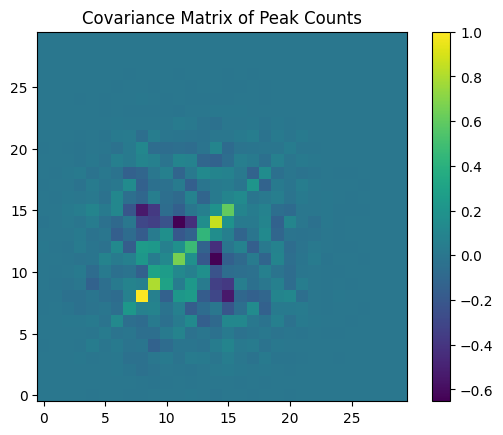

In [16]:
plotting.plot_map(covariance_matrix_normalized, title='Covariance Matrix of Peak Counts', cmap='viridis', vmin=None, vmax=None)

## Multiscale peak counts datavector

In [8]:
# Constants and Parameters
N_GAL = 7
PIX_ARCMIN = 0.4
SHAPE_NOISE = 0.44
NSCALES = 5
NBINS = 40
KAPPA_SNR = np.linspace(-2, 6, 31)
NUM_REALIZATIONS = 124  # Number of realizations

In [18]:
# Initialize an empty list to store data the Multi-Scale Peak Counts vectors for each realization
MS_PC_data_vectors = []

# Loop over realizations
for realization_files in collections_of_files[:10]:  # Use only the first ... realizations for now
    # Initialize an empty list to store peak counts vectors for each scale in this realization
    peak_counts_realization = []

    # Loop over files (tiles) in this realization
    for tile_file in realization_files:
        # Load the catalog data for this tile
        catalog_data = slics.read_catalogue_pd(tile_file)

        # Extract data from the catalog
        ra = catalog_data['RA']
        dec = catalog_data['Dec']
        g1_sim = catalog_data['gamma1_sim']
        g2_sim = catalog_data['gamma2_sim']

        # Calculate shear and kappa maps
        e1map, e2map = mapping.bin_shear_field(ra, dec, g1_sim, g2_sim)
        kappaE, _ = ks93(e1map, -e2map)

        # Add noise to the kappa map
        kappaE_noisy, noise_map_CFIS_z05 = mapping.add_noise_to_kappa_map(kappaE, SHAPE_NOISE, N_GAL, PIX_ARCMIN)

        # Smooth the noisy kappa map
        kappaE_noisy_smoothed = mapping.smooth_kappa_map(kappaE_noisy, PIX_ARCMIN)

        # Compute SNR map
        snr = mapping.convert_to_snr_map(kappaE_noisy_smoothed, kappaE_noisy_smoothed)

        # Compute multiscale SNR maps
        multiscale_snr_maps = mapping.compute_multiscale_snr_maps(kappaE, noise_map_CFIS_z05, NSCALES)

        # Compute peak counts for each scale
        kappa_th_center_snr, peak_counts_multi = summary_statistics.compute_multiscale_peak_counts(multiscale_snr_maps, KAPPA_SNR)

        # Append peak counts for this tile to the list for this realization
        peak_counts_realization.append(peak_counts_multi)

    # Compute the average peak counts vector for this realization
    average_peak_counts = np.mean(peak_counts_realization, axis=0)

    # Append the average peak counts vector for this realization to the list of data vectors
    MS_PC_data_vectors.append(average_peak_counts)

# Convert the list of data vectors into a NumPy array
MS_PC_data_vectors = np.array(MS_PC_data_vectors)

In [20]:
# save the data vectors to a file
np.save('.././output/MS_PC_data_vectors.npy', MS_PC_data_vectors)

In [4]:
# load the data vectors from a file
MS_PC_data_vectors = np.load('.././output/MS_PC_data_vectors.npy')

In [5]:
data_vectors_reshaped = MS_PC_data_vectors.reshape(10, -1)  

# Compute the average peak counts vector across all realizations for multiscale peak counts
mean_PC_over_realizations_multi = np.mean(data_vectors_reshaped, axis=0)

# Compute the deviations of peak counts in each realization from the average vector
deviations_multi = data_vectors_reshaped - mean_PC_over_realizations_multi

# Compute the covariance matrix for multiscale peak counts
num_realizations_multi, num_bins_multi = data_vectors_reshaped.shape
covariance_matrix_multi = np.dot(deviations_multi.T, deviations_multi) / (num_realizations_multi - 1)

# Normalize the covariance matrix for multiscale peak counts
diagonal_multi = np.sqrt(np.diag(covariance_matrix_multi))
# Add a small epsilon to the diagonal to avoid division by zero
epsilon = 1e-10
covariance_matrix_normalized_multi = covariance_matrix_multi / (np.outer(diagonal_multi, diagonal_multi)+epsilon)

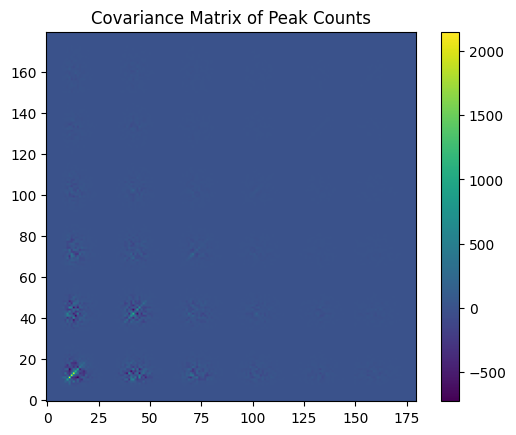

In [8]:
plotting.plot_map(covariance_matrix_multi, title='Covariance Matrix of Peak Counts', cmap='viridis', vmin=None, vmax=None)

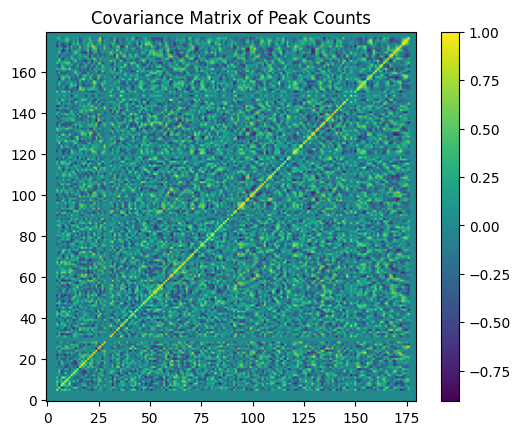

In [9]:
plotting.plot_map(covariance_matrix_normalized_multi, title='Covariance Matrix of Peak Counts', cmap='viridis', vmin=None, vmax=None)

## l1-norm datavector

In [21]:
# Initialize an empty list to store data vectors for the L1-norm histogram for each realization
L1_norm_data_vectors = []

# Loop over realizations
for realization_files in collections_of_files[:10]:  # Use only the first ... realizations for now
    # Initialize an empty list to store L1-norm histogram vectors for each scale in this realization
    l1_norm_histogram_realization = []

    # Loop over files (tiles) in this realization
    for tile_file in realization_files:
        # Load the catalog data for this tile
        catalog_data = slics.read_catalogue_pd(tile_file)

        # Extract data from the catalog
        ra = catalog_data['RA']
        dec = catalog_data['Dec']
        g1_sim = catalog_data['gamma1_sim']
        g2_sim = catalog_data['gamma2_sim']

        # Calculate shear and kappa maps
        e1map, e2map = mapping.bin_shear_field(ra, dec, g1_sim, g2_sim)
        kappaE, _ = ks93(e1map, -e2map)

        # Add noise to the kappa map
        kappaE_noisy, noise_map_CFIS_z05 = mapping.add_noise_to_kappa_map(kappaE, SHAPE_NOISE, N_GAL, PIX_ARCMIN)

        # Compute the L1-norm histogram for each scale
        bins_l1, l1norm_histogram = get_l1norm_noisy(kappaE, noise_map_CFIS_z05, NSCALES, NBINS*2)

        # Append the L1-norm histogram for this tile to the list for this realization
        l1_norm_histogram_realization.append(l1norm_histogram)

    # Compute the average L1-norm histogram vector for this realization
    average_l1_norm_histogram = np.mean(l1_norm_histogram_realization, axis=0)

    # Append the average L1-norm histogram vector for this realization to the list of data vectors
    L1_norm_data_vectors.append(average_l1_norm_histogram)

# Convert the list of data vectors into a NumPy array
L1_norm_data_vectors = np.array(L1_norm_data_vectors)


In [23]:
# save the data vectors to a file
np.save('.././output/L1_norm_data_vectors.npy', L1_norm_data_vectors)

In [10]:
# load the data vectors from a file
L1_norm_data_vectors = np.load('.././output/L1_norm_data_vectors.npy')

In [12]:
L1_norm_data_vectors_reshaped = L1_norm_data_vectors.reshape(10, -1)

# Compute the average L1-norm histogram vector across all realizations for the L1-norm
mean_L1_norm_over_realizations = np.mean(L1_norm_data_vectors_reshaped, axis=0)

# Compute the deviations of L1-norm histograms in each realization from the average vector
deviations_L1_norm = L1_norm_data_vectors_reshaped - mean_L1_norm_over_realizations

# Compute the covariance matrix for the L1-norm histograms
num_realizations_L1_norm, num_bins_L1_norm = L1_norm_data_vectors_reshaped.shape
covariance_matrix_L1_norm = np.dot(deviations_L1_norm.T, deviations_L1_norm) / (num_realizations_L1_norm - 1)

# Calculate the diagonal of the covariance matrix
diagonal_L1_norm = np.sqrt(np.diag(covariance_matrix_L1_norm))

# Calculate the correlation coefficients
correlation_matrix_L1_norm = covariance_matrix_L1_norm / np.outer(diagonal_L1_norm, diagonal_L1_norm)

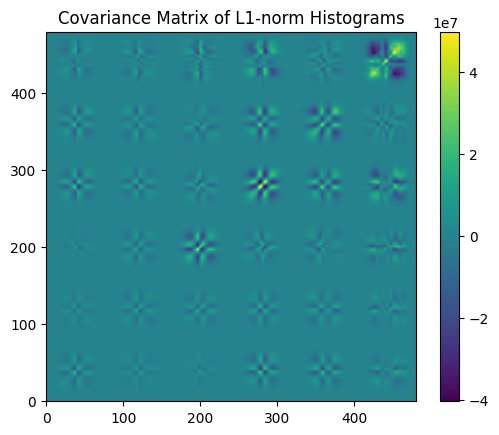

In [13]:
plotting.plot_map(covariance_matrix_L1_norm, title='Covariance Matrix of L1-norm Histograms', cmap='viridis', vmin=None, vmax=None)

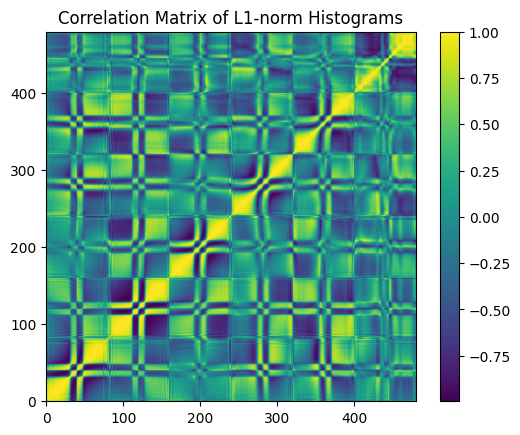

In [14]:
plotting.plot_map(correlation_matrix_L1_norm, title='Correlation Matrix of L1-norm Histograms', cmap='viridis', vmin=None, vmax=None)